# **Objective:**

To develop a robust predictive model to forecast the future stock price of Apple Inc. (AAPL) using LSTM, ARIMA, SARIMA, Ensemble methods.

#Step 1: Importing Libraries

In [ ]:
#Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt

#Step 2: Loading Dataset

In [ ]:
#Importing the csv file
data = pd.read_csv('/content/sample_data/Apple.csv')
#Display first row
data.head(5)

,Open,High,Low,Close,Adj Close,Volume,Date
0,0.94,1.00,0.91,1.00,0.85,535796800,2000-01-03
1,0.97,0.99,0.90,0.92,0.78,512377600,2000-01-04
2,0.93,0.99,0.92,0.93,0.79,778321600,2000-01-05
3,0.95,0.96,0.85,0.85,0.72,767972800,2000-01-06
4,0.86,0.90,0.85,0.89,0.76,460734400,2000-01-07


In [ ]:
#Displaying the summary of records, features(inclusive of outcome)
summary_table = pd.DataFrame({
    'Total Records': [data.shape[0]],
    'Total Features': [data.shape[1]],
})
print(summary_table)

   Total Records  Total Features
0           5839               7


In [ ]:
#Displaying data types feature-wise in a table
data_types_table = pd.DataFrame(data.dtypes, columns=['Data Type']).rename_axis('Features').reset_index()
print(data_types_table)

    Features Data Type
0       Open   float64
1       High   float64
2        Low   float64
3      Close   float64
4  Adj Close   float64
5     Volume     int64
6       Date    object


#Step 3: Data Cleaning and Preprocessing

In [ ]:
# Checking the number of duplicate rows
duplicate_data_count = data.duplicated().sum()
# Displaying the result
print("Number of Duplicate Rows:", duplicate_data_count)

Number of Duplicate Rows: 0


In [ ]:
# Checking the total number of missing data for each column in the dataset
missing_data_count = data.isna().sum()
# Displaying the result
print("\nColumn wise missing data count:")
print(missing_data_count)


Column wise missing data count:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Date         0
dtype: int64


In [ ]:
# Checking for Outliers
pd.options.display.float_format = '{:.2f}'.format
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5839.00,5839.00,5839.00,5839.00,5839.00,5839.00
mean,30.96,31.32,30.62,30.98,29.76,411287346.69
std,44.29,44.84,43.77,44.33,44.16,386727674.95
min,0.23,0.24,0.23,0.23,0.20,35195900.00
25%,1.93,1.96,1.90,1.93,1.64,138435600.00
50%,13.32,13.52,13.16,13.36,11.37,294224000.00
75%,36.44,36.80,36.24,36.58,34.38,547639400.00
max,182.63,182.94,179.12,182.01,180.68,7421640800.00


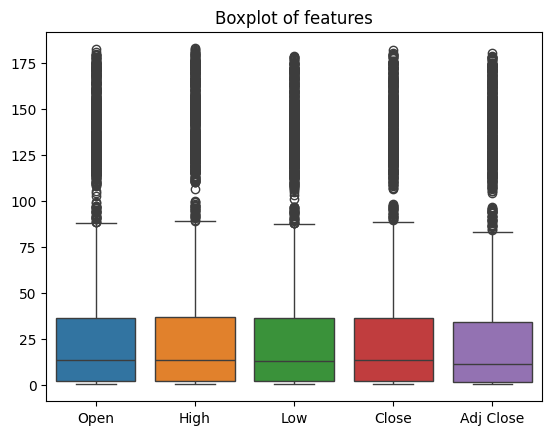

In [ ]:
#Ploting the feature values using a boxplot
features_to_plot = ['Open','High','Low','Close','Adj Close']
sns.boxplot(data=data[features_to_plot])
plt.title("Boxplot of features")
plt.show()

In [ ]:
#Normalize the dataset to improve the computational speed and acheive better results
normalization_columns = ['Open',	'High'	, 'Low'	,'Close',	'Adj Close', 'Volume']
scaler = MinMaxScaler()
data_n = data.copy()
data_n[normalization_columns] = scaler.fit_transform(data_n[normalization_columns])
data_n.describe()


,Open,High,Low,Close,Adj Close,Volume
count,5839.00,5839.00,5839.00,5839.00,5839.00,5839.00
mean,0.17,0.17,0.17,0.17,0.16,0.05
std,0.24,0.25,0.24,0.24,0.24,0.05
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.01,0.01,0.01,0.01,0.01,0.01
50%,0.07,0.07,0.07,0.07,0.06,0.04
75%,0.20,0.20,0.20,0.20,0.19,0.07
max,1.00,1.00,1.00,1.00,1.00,1.00


<Axes: >

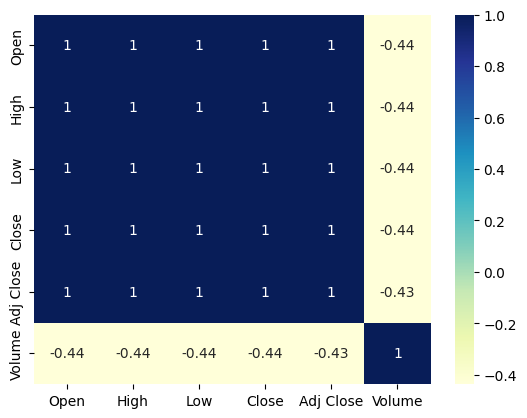

In [ ]:
# Checking for correlation using heatmap to understand the strength and direction of the linear relationship between features.

# Drop the date column
data_n_no_date = data_n.drop(columns=['Date'])

# Calculate the correlation matrix
correlation_matrix = data_n_no_date.corr()
sns.heatmap(correlation_matrix,annot = True , cmap="YlGnBu")


It is evident from the heatmap that the Opening Price feature is highly correlated to Close, High, Low, Adj Close Prices of the Stock.

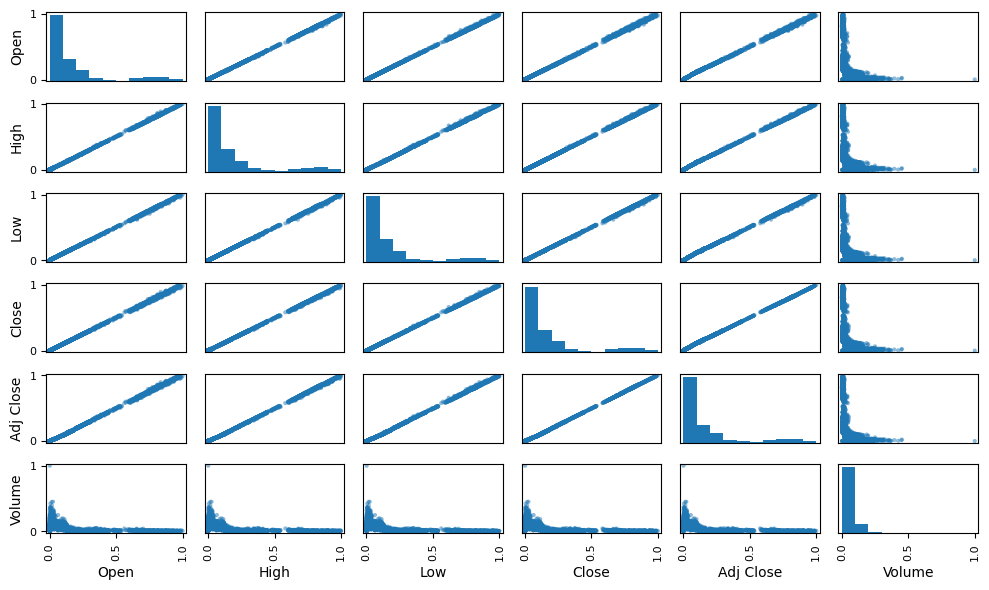

In [ ]:
# Visualize relationships between different features using scatter matrix
from pandas.plotting import scatter_matrix

# Drop the date column
data_n_no_date = data_n.drop(columns=['Date'])

# Create the scatter matrix
scatter_matrix(data_n_no_date, figsize=(10, 6))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Visualization:

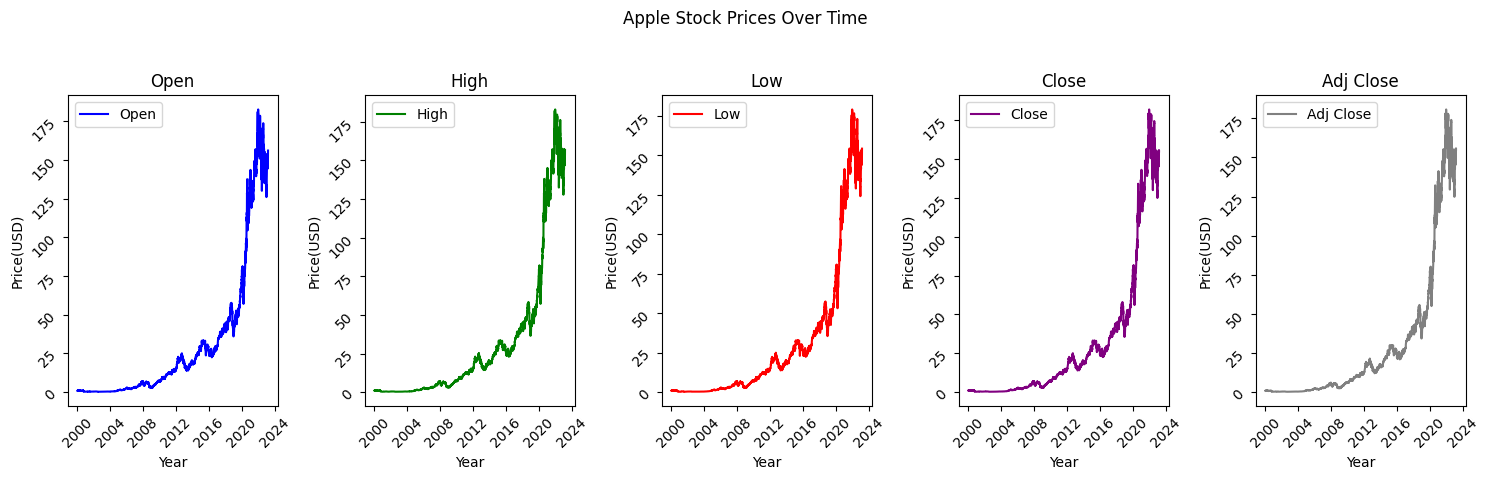

In [ ]:
# Assuming 'data' is your DataFrame after loading and converting 'Date'
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Set up the matplotlib figure and axes for a 1x5 grid
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
fig.suptitle('Apple Stock Prices Over Time')

# Titles for each subplot
sub_titles = ['Open', 'High', 'Low', 'Close', 'Adj Close']

# Colors for each plot
colors = ['blue', 'green', 'red', 'purple', 'grey']

# Plot each stock price type in its own subplot
for i, col in enumerate(sub_titles):
    axes[i].plot(data['Date'], data[col], label=col, color=colors[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Price(USD)')
    axes[i].legend()
    axes[i].grid(False)
    axes[i].tick_params(labelrotation=45)

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Analyzing Previous Quarter's Data

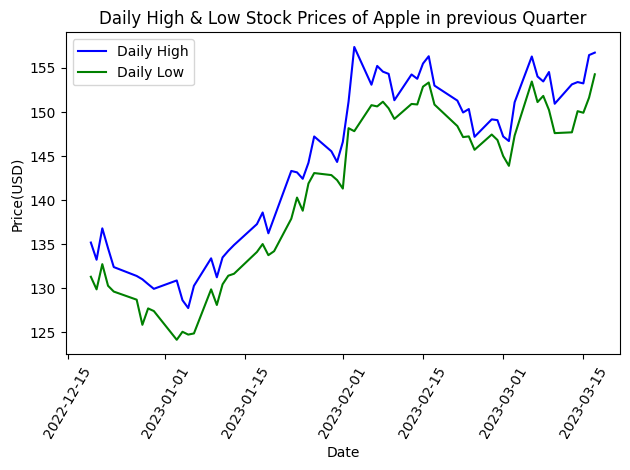

In [ ]:
# Convert 'Date' column to datetime
#data['Date'] = pd.to_datetime(data['Date'])

# Get the maximum date from the dataset which represents the latest stock data
latest_date = data['Date'].max()

# Calculate the date one quarter prior to the latest date
one_quarter_prior = latest_date - pd.Timedelta(days=90)

# Filter the data to get the range between quarter prior and the latest date
one_quarter_data = data.loc[(data['Date'] >= one_quarter_prior) & (data['Date'] <= latest_date)]

# Plot daily high and low prices for the previous year
plt.plot(one_quarter_data['Date'], one_quarter_data['High'], color='blue', label='Daily High')
plt.plot(one_quarter_data['Date'], one_quarter_data['Low'], color='green', label='Daily Low')

# Plotting
plt.title('Daily High & Low Stock Prices of Apple in previous Quarter')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(False)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

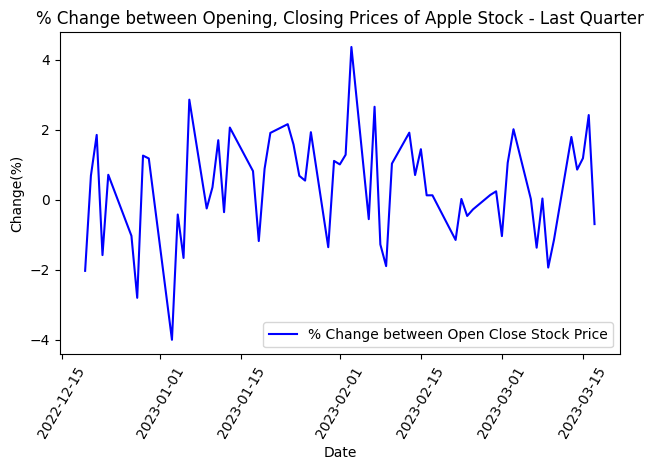

In [ ]:
# Filter the data for the previous quarter from the recent date and make a copy
quarter_data = data[data['Date'] >= one_quarter_prior].copy()

# Calculate the percentage change between the opening and closing price for the last 6 months
quarter_data.loc[:, '% Change in last Quarter'] = ((quarter_data['Close'] - quarter_data['Open']) / quarter_data['Open']) * 100

# Plotting the percentage change for previous quarter
plt.plot(quarter_data['Date'], quarter_data['% Change in last Quarter'], color='blue', label='% Change between Open Close Stock Price')

# Plotting
plt.title('% Change between Opening, Closing Prices of Apple Stock - Last Quarter')
plt.xlabel('Date')
plt.ylabel('Change(%)')
plt.legend()
plt.grid(False)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

### Analyzing previous year's Data

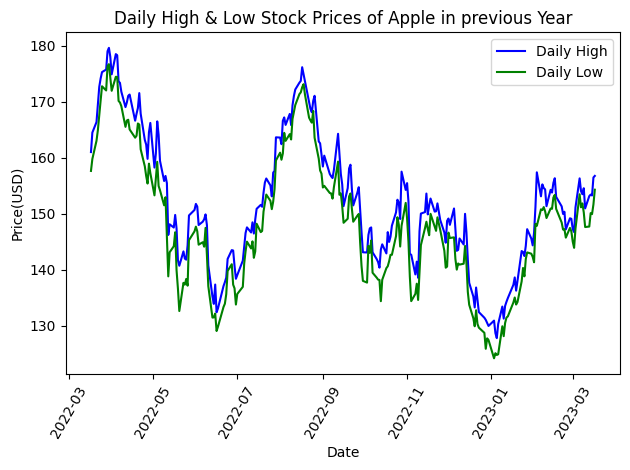

In [ ]:
# Calculate the date one year prior to the latest date
one_year_prior = latest_date - pd.Timedelta(days=365)

# Filter the data to get the range between one year prior and the latest date
one_year_data = data.loc[(data['Date'] >= one_year_prior) & (data['Date'] <= latest_date)]

# Plot daily high and low prices for the previous year
plt.plot(one_year_data['Date'], one_year_data['High'], color='blue', label='Daily High')
plt.plot(one_year_data['Date'], one_year_data['Low'], color='green', label='Daily Low')

# Plotting
plt.title('Daily High & Low Stock Prices of Apple in previous Year')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(False)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


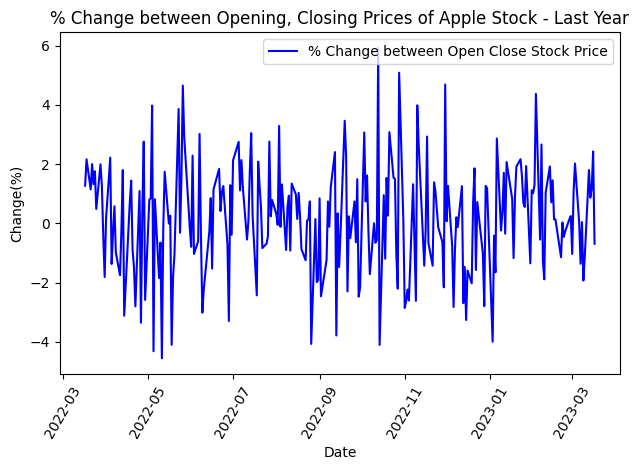

In [ ]:
# Filter the data for the previous year from the recent date and make a copy
year_data = data[data['Date'] >= one_year_prior].copy()

# Calculate the percentage change between the opening and closing price for the last 6 months
year_data.loc[:, '% Change in last Year'] = ((year_data['Close'] - year_data['Open']) / year_data['Open']) * 100

# Plotting the percentage change for previous quarter
plt.plot(year_data['Date'], year_data['% Change in last Year'], color='blue', label='% Change between Open Close Stock Price')

# Plotting
plt.title('% Change between Opening, Closing Prices of Apple Stock - Last Year')
plt.xlabel('Date')
plt.ylabel('Change(%)')
plt.legend()
plt.grid(False)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

It is evident from the daily High, Low prices plot that there was an increase in the stock price in the previous quarter and significant drops and gains in the previous year. However, while the previous year graph starts with a decline followed by some recovery, the quarter graph suggests that the recovery has continued and become more established.

The graphs show significant changes in opening and closing stock prices over the last year. Differences decreased in May, increased until July, then decreased until October. A similar pattern occurred from October to January, with frequent daily fluctuations in stock prices.


In [ ]:
# Perform ADFuller Test to check stationarity of Opening Prices
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_n['Open'])
print(f'Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')


Statistic: 1.4018827950284118
p-value: 0.9971226783787581
Critical Values:
1%: -3.431475634981753
5%: -2.86203742423918
10%: -2.567034776894424


Given the test statistic, p-value, and critical values, the ADF test suggests that the data is non-stationary because:
The test statistic is positive and greater than all critical values.
The p-value is very high, indicating a lack of evidence to reject the null hypothesis of non-stationarity.

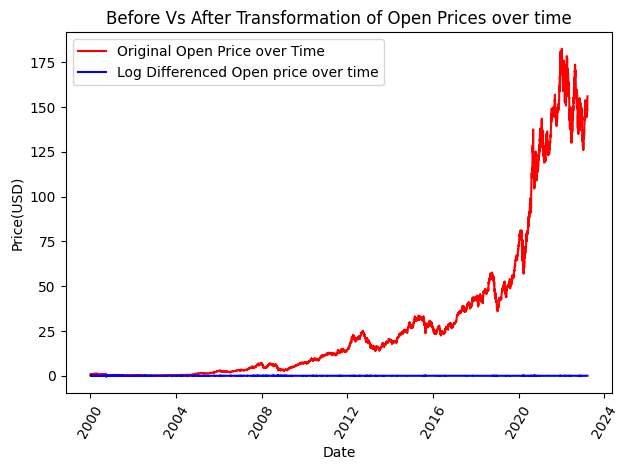

In [ ]:
# Applying log difference transformation to get stationary data
data_n=data.copy()
data_n['Log_Diff_Open'] = np.log(data_n['Open'] + 1e-10).diff()
data_n = data_n.dropna(axis=0)

# Plot daily high and low prices for the previous year
plt.plot(data['Date'], data['Open'], color='red', label='Original Open Price over Time')
plt.plot(data_n['Date'], data_n['Log_Diff_Open'], color='blue', label='Log Differenced Open price over time')

# Plotting
plt.title('Before Vs After Transformation of Open Prices over time')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(False)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

In [ ]:
# Perform ADFuller Test to check stationarity of Opening Prices
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_n['Log_Diff_Open'])
print(f'Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

Statistic: -14.519198012008246
p-value: 5.5601367677374254e-27
Critical Values:
1%: -3.4314758287750426
5%: -2.862037509861278
10%: -2.5670348224735093


The ADF test results suggest that the data is stationary. The very negative test statistic and very low p-value provide strong evidence against the null hypothesis of non-stationarity. The test statistic being much more negative than the critical values at all significance levels confirms the rejection of the null hypothesis.

## Deciding Order for ARIMA

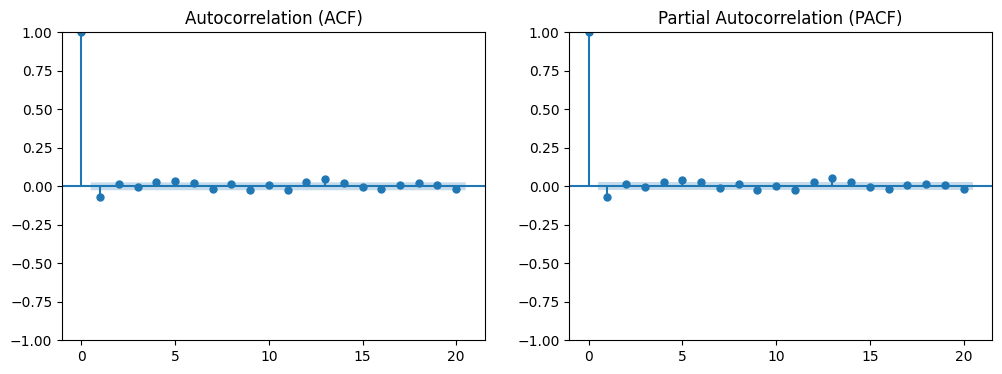

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(data_n['Log_Diff_Open'], lags=20, ax=ax1)
ax1.set_title('Autocorrelation (ACF)')

plot_pacf(data_n['Log_Diff_Open'], lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF)')

plt.show()

The lags where ACF and PACF drop significantly to zero indicate the orders of MA and AR components, respectively. Thus, we conclude saying that AR component = 1, MA Component = 1, Differencing component = 1(since by performing log differncing once, we got p-value less than 0.05). So, the best ARIMA model would be ARIMA(1,1,1).

# Step 4:Data Splitting

## LSTM Model

In [ ]:
# Open is the column we want to predict
dataset = ['Open', 'High', 'Low', 'Close','Volume']

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[dataset])

def create_dataset(dataset, look_back=1):
  X, Y = [], []
  for i in range(len(dataset)-look_back):
    X.append(dataset[i:(i+look_back), :])
    Y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(Y)

look_back = 180
X, Y = create_dataset(scaled_data, look_back)
X = X.reshape(X.shape[0], X.shape[1], len(dataset))

train_size = int(len(X) * 0.80)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]


## ARIMA, SARIMA Model

In [ ]:
## Data splitting for ARIMA-SARIMA
time_series = data_n['Log_Diff_Open']

# Calculate the split index
split_index = int(len(time_series) * 0.8)  # 80% of the length of the data

# Split the data into training and testing sets
train_data,test_data  = time_series[:split_index],time_series[split_index:]


# Step 5: Model Fitting and Evaluation

## LSTM Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
# Add first LSTM layer with return_sequences=True
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], len(dataset))))
model.add(Dropout(0.2))
# Add second LSTM layer without return_sequences (default is False)
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/100
142/142 [==============================] - 62s 336ms/step - loss: 2.6700e-04 - val_loss: 5.5436e-04
Epoch 2/100
142/142 [==============================] - 38s 268ms/step - loss: 6.0545e-05 - val_loss: 0.0013
Epoch 3/100
142/142 [==============================] - 39s 274ms/step - loss: 5.8805e-05 - val_loss: 0.0025
Epoch 4/100
142/142 [==============================] - 38s 266ms/step - loss: 6.1147e-05 - val_loss: 0.0012
Epoch 5/100
142/142 [==============================] - 38s 271ms/step - loss: 5.1803e-05 - val_loss: 0.0017
Epoch 6/100
142/142 [==============================] - 38s 266ms/step - loss: 4.6748e-05 - val_loss: 0.0016
Epoch 7/100
142/142 [==============================] - 38s 270ms/step - loss: 4.2264e-05 - val_loss: 4.3481e-04
Epoch 8/100
142/142 [==============================] - 37s 263ms/step - loss: 3.8219e-05 - val_loss: 6.9430e-04
Epoch 9/100
142/142 [==============================] - 37s 264ms/step - loss: 3.8254e-05 - val_loss: 4.3205e-04
Epoch 10/100

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

36/36 [==============================] - 3s 74ms/step


In [ ]:
train_rmse_lstm = sqrt(mean_squared_error(Y_train, train_predict))
test_rmse_lstm = sqrt(mean_squared_error(Y_test, test_predict))
print('Train RMSE: {:.2f}'.format(train_rmse_lstm))
print('Test RMSE: {:.2f}'.format(test_rmse_lstm))

Train RMSE: 0.00
Test RMSE: 0.02


In [ ]:
import warnings

warnings.filterwarnings("ignore")

last_days = data[-look_back:]
last_days_scaled = scaler.transform(last_days[dataset])
X_last_days_scaled = last_days_scaled.reshape(1, look_back, len(dataset))

next_day_open_price_scaled = model.predict(X_last_days_scaled)
dummy_array = np.zeros((1, len(dataset)))
dummy_array[0, 0] = next_day_open_price_scaled

next_day_open_price = scaler.inverse_transform(dummy_array)[0, 0]

print(f"Predicted next day's opening price: {next_day_open_price}")



1/1 [==============================] - 0s 66ms/step
Predicted next day's opening price: 151.92752722945892


In [ ]:
import warnings
warnings.filterwarnings("ignore")
six_months_days = 180

predicted_prices = []

for i in range(len(data) - six_months_days - look_back, len(data) - look_back):
    X_input = data[i:i+look_back][dataset]
    X_input_scaled = scaler.transform(X_input)
    X_input_scaled = X_input_scaled.reshape(1, look_back, len(dataset))

    predicted_scaled = model.predict(X_input_scaled)
    dummy_array = np.zeros((1, len(dataset)))
    dummy_array[0, 0] = predicted_scaled
    predicted_price = scaler.inverse_transform(dummy_array)[0, 0]
    predicted_prices.append(predicted_price)

actual_prices_6 = data['Open'][-(six_months_days):]
print(predicted_prices)


1/1 [==============================] - 0s 69ms/step
[139.30819580043695, 138.26190748562684, 137.86534878727156, 138.3954019547875, 139.76325549549827, 141.56513185548036, 143.15597627956555, 143.7819510776218, 144.35915511351058, 144.14565528572516, 144.54774771523142, 145.9646655559114, 146.75047712289026, 147.32297368218104, 148.50885552936538, 150.04795032618412, 151.17382000057205, 151.4563229553029, 151.0240178757602, 151.5915786512739, 152.6479016101947, 154.9721121806845, 156.5922668978601, 157.11553608062516, 158.28503416976525, 159.74260156009848, 160.27714476880374, 160.89686829886037, 160.94478019116357, 162.0713782741706, 163.2389955470256, 164.45182851311614, 165.6464186484182, 166.49225325996386, 167.34719841513333, 167.87055457206185, 167.67903746409422, 166.3690761009452, 165.13718492128362, 164.38452138235846, 164.6264074027474, 164.19773349452967, 162.17701926747904, 160.3700549189338, 158.81158662720142, 157.3858409089289, 156.6801869053609, 155.64706430454652, 154.

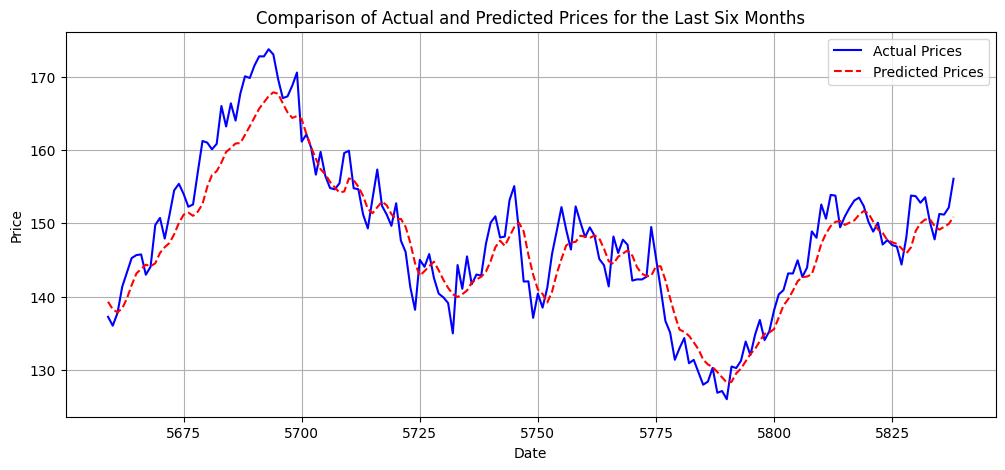

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(12, 5))
plt.plot(actual_prices_6.index, actual_prices_6.values, label='Actual Prices', color='blue')
plt.plot(actual_prices_6.index, predicted_prices, label='Predicted Prices', color='red', linestyle='--')

plt.title('Comparison of Actual and Predicted Prices for the Last Six Months')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


## ARIMA Model

In [ ]:
# Comparison with models of different orders to find the best fit model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

orders = [(1,1,1), (1,0,1), (0,1,1), (1,1,0),(2,1,1)]
metrics = []
for order in orders:
    # Fit the ARIMA model
    arima_model = sm.tsa.ARIMA(train_data, order=order)
    fitted_model = arima_model.fit()

    # Calculate and print the Mean Squared Error (MSE)
    mse = mean_squared_error(train_data, fitted_model.fittedvalues)

    # Calculate and print the Root Mean Squared Error (RMSE)
    rmse = mse**0.5

    # Performance Metrics
    metrics.append({
        'Model': f'ARIMA{order}',
        'AIC': fitted_model.aic,
        'BIC': fitted_model.bic,
        'RMSE': rmse
    })

# Convert the metrics list to a DataFrame
df_metrics = pd.DataFrame(metrics)

# Print the DataFrame as a table
print(df_metrics)


            Model       AIC       BIC  RMSE
0  ARIMA(1, 1, 1) -20524.23 -20504.89  0.03
1  ARIMA(1, 0, 1) -20537.41 -20511.61  0.03
2  ARIMA(0, 1, 1) -20500.15 -20487.26  0.03
3  ARIMA(1, 1, 0) -18598.74 -18585.85  0.03
4  ARIMA(2, 1, 1) -20524.07 -20498.28  0.03


ARIMA(1,0,1) is the best-performing model in the group, with the lowest AIC and low BIC, and similar RMSE as other models. ARIMA(1,1,1) and ARIMA(2,1,1) models have similar performance, with slightly higher AIC and BIC than ARIMA(1,0,1), making them less optimal choices. ARIMA(0,1,1) and ARIMA(1,1,0) models have higher AIC and BIC values and similar RMSE compared to other models, suggesting they may not be the best choices for the data.
Based on the table, ARIMA(1,0,1) appears to be the most favorable model due to its low AIC and BIC values while maintaining an RMSE similar to the other models.

In [ ]:
from math import sqrt
model_best_arima = sm.tsa.ARIMA(train_data, order=(1,0,1))
results_best_arima = model_best_arima.fit()
predictions = results_best_arima.forecast(steps=len(test_data))

mse = mean_squared_error(train_data, results_best_arima.fittedvalues)
train_rmse_arima = np.sqrt(mse)
print('Train RMSE: %.3f' % train_rmse_arima)

mse = mean_squared_error(test_data, predictions)
test_rmse_arima = sqrt(mse)
print('Test RMSE: %.3f' % test_rmse_arima)

Train RMSE: 0.027
Test RMSE: 0.021


4670


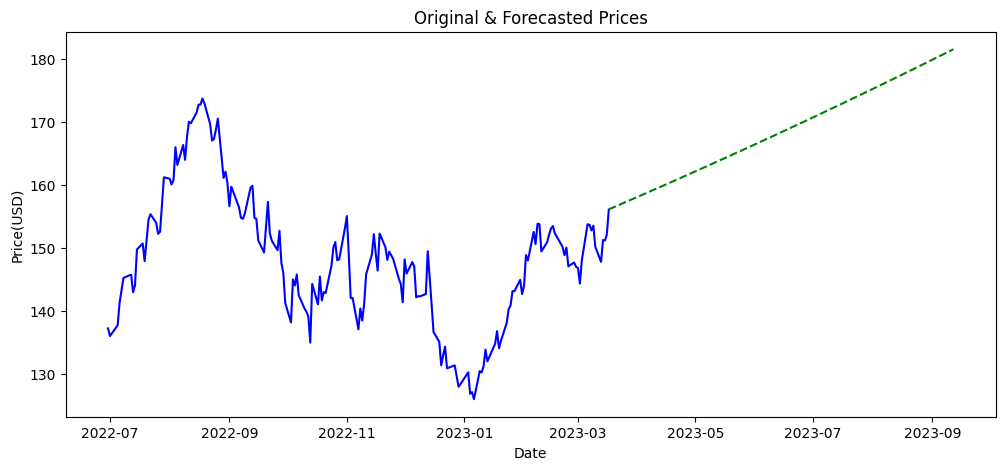

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fit the ARIMA model
arima_model_101 = sm.tsa.ARIMA(train_data, order=(1, 0, 1))
fitted_model_101 = arima_model_101.fit()

# Forecast future values for the specified number of steps
forecast= fitted_model_101.forecast(steps=180)

# Reverse Log Differencing:
cumsum_forecast = np.cumsum(forecast)
last_actual_value_log_differenced = np.log(data_n['Open'].iloc[-1])
predicted_log_values = last_actual_value_log_differenced + cumsum_forecast

# Reverse Normalization
normalization_min = 0
normalization_max = 1

# Apply inverse normalization to the predicted log values
predicted_original_values = np.exp(predicted_log_values)
print(predicted_original_values.index[0])

# Use original series and find the maximum date in the series
original_series = data['Open']
start_date = data['Date'].loc[original_series.index.max()]

# Create a date range for forecast index
forecast_index = pd.date_range(start=start_date, periods=len(forecast), freq='D')  # 'D' stands for daily frequency.

# Calculate the date six months ago from the last date in the original series
six_months_ago = original_series.index.max() - 179

# Filter the data for the last six months
original_series_last_6_months = data['Open'].loc[six_months_ago:]

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(data['Date'].loc[six_months_ago:], original_series_last_6_months, label='Original Data', color='blue')
plt.plot(forecast_index, predicted_original_values, label='Forecasted Data', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.title('Original & Forecasted Prices')
predicted_original_values
plt.show()


## SARIMA Model

In [59]:
import numpy as np
import pandas as pd
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Suppress warnings
warnings.filterwarnings("ignore")

# Initialize the metrics list
metrics = []

# Define the seasonal cycle lengths (e.g., daily, weekly, monthly)
seasonal_order = [5, 21]

# Range for possible seasonal parameters
P_vals = [0, 1, 2]  # Seasonal AR order
D_vals = [0, 1]  # Seasonal differencing order
Q_vals = [0, 1, 2]  # Seasonal MA order

# Iterate through combinations of seasonal SARIMA parameters
for P in P_vals:
  for D in D_vals:
    for Q in Q_vals:
      for s_order in seasonal_order:
        # Fit the SARIMA model
        model = SARIMAX(train_data, order=(1, 0, 1), seasonal_order=(1, 1, 1, s_order))
        result = model.fit()
        # Calculate and print the Mean Squared Error (MSE)
        mse = mean_squared_error(train_data, result.fittedvalues)

        # Calculate and print the Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)

        # Store performance metrics
        metrics.append({
            'Model': f'SARIMA(1,0,1,({P},{D},{Q},{s_order}))',
            'AIC': result.aic,
            'BIC': result.bic,
            'RMSE': rmse
        })

# Convert the metrics list to a DataFrame
df_metrics = pd.DataFrame(metrics)

# Print the DataFrame as a table
print(df_metrics)

                       Model       AIC       BIC  RMSE
0    SARIMA(1,0,1,(0,0,0,5)) -20486.49 -20454.25  0.03
1   SARIMA(1,0,1,(0,0,0,21)) -20328.08 -20295.85  0.03
2    SARIMA(1,0,1,(0,0,1,5)) -20486.49 -20454.25  0.03
3   SARIMA(1,0,1,(0,0,1,21)) -20328.08 -20295.85  0.03
4    SARIMA(1,0,1,(0,0,2,5)) -20486.49 -20454.25  0.03
5   SARIMA(1,0,1,(0,0,2,21)) -20328.08 -20295.85  0.03
6    SARIMA(1,0,1,(0,1,0,5)) -20486.49 -20454.25  0.03
7   SARIMA(1,0,1,(0,1,0,21)) -20328.08 -20295.85  0.03
8    SARIMA(1,0,1,(0,1,1,5)) -20486.49 -20454.25  0.03
9   SARIMA(1,0,1,(0,1,1,21)) -20328.08 -20295.85  0.03
10   SARIMA(1,0,1,(0,1,2,5)) -20486.49 -20454.25  0.03
11  SARIMA(1,0,1,(0,1,2,21)) -20328.08 -20295.85  0.03
12   SARIMA(1,0,1,(1,0,0,5)) -20486.49 -20454.25  0.03
13  SARIMA(1,0,1,(1,0,0,21)) -20328.08 -20295.85  0.03
14   SARIMA(1,0,1,(1,0,1,5)) -20486.49 -20454.25  0.03
15  SARIMA(1,0,1,(1,0,1,21)) -20328.08 -20295.85  0.03
16   SARIMA(1,0,1,(1,0,2,5)) -20486.49 -20454.25  0.03
17  SARIMA

Since all models have the same RMSE value of 0.03, and the models with a seasonal order of 5 have lower AIC and BIC values compared to models with a seasonal order of 21, it is clear that the best model would be one with a seasonal order of 5.

In [60]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

order = (1, 0, 1)
seasonal_order = (1, 1, 1, 5)
model_SARIMA_5 = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)

results_SARIMA5 = model_SARIMA_5.fit()
predictions = results_SARIMA5.forecast(steps=len(test_data))

mse = mean_squared_error(train_data, results_SARIMA5.fittedvalues)
train_rmse_sarima = np.sqrt(mse)
print('Train RMSE: %.3f' % train_rmse_sarima)

mse = mean_squared_error(test_data, predictions)
test_rmse_sarima = sqrt(mse)
print('Test RMSE: %.3f' % test_rmse_sarima)


Train RMSE: 0.027
Test RMSE: 0.021


4670


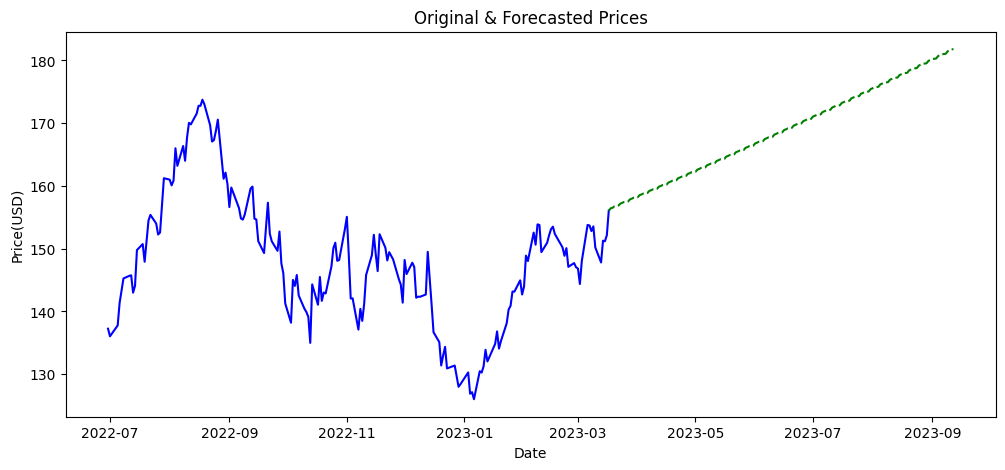

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model
sarima_model_1115 = SARIMAX(train_data, order=(1, 0, 1), seasonal_order=(1, 1, 1, 5))
fitted_model_1115 = sarima_model_1115.fit()

# Forecast future values for the specified number of steps
forecast1= fitted_model_1115.forecast(steps=180)

# Reverse Log Differencing:
cumsum_forecast1 = np.cumsum(forecast1)
last_actual_value_log_differenced1 = np.log(data_n['Open'].iloc[-1])
predicted_log_values1 = last_actual_value_log_differenced1 + cumsum_forecast1

# Reverse Normalization
normalization_min = 0
normalization_max = 1

# Apply inverse normalization to the predicted log values
predicted_original_values1 = np.exp(predicted_log_values1)
print(predicted_original_values1.index[0])

# Use original series and find the maximum date in the series
original_series = data['Open']
start_date = data['Date'].loc[original_series.index.max()]

# Create a date range for forecast index
forecast1_index = pd.date_range(start=start_date, periods=len(forecast1), freq='D')  # 'D' stands for daily frequency.

# Calculate the date six months ago from the last date in the original series
six_months_ago = original_series.index.max() - 179

# Filter the data for the last six months
original_series_last_6_months = data['Open'].loc[six_months_ago:]

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(data['Date'].loc[six_months_ago:], original_series_last_6_months, label='Original Data', color='blue')
plt.plot(forecast1_index, predicted_original_values1, label='Forecasted Data', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.title('Original & Forecasted Prices')
predicted_original_values
plt.show()


In [63]:
# Weights based on RMSE Obtained
lstm_weight = 0.3
arima_weight = 0.35
sarima_weight = 0.35

In [64]:
import numpy as np

# Convert the predictions to numpy arrays
predicted_prices_array = np.array(predicted_prices)
predicted_original_values_array = np.array(predicted_original_values)
predicted_original_values1_array = np.array(predicted_original_values1)

# Combine predictions using weighted average
ensemble_forecast = (predicted_prices_array * lstm_weight) + (predicted_original_values_array * arima_weight) + (predicted_original_values1_array * sarima_weight)


In [65]:
import numpy as np

def rmse(actual, predicted):
  squared_errors = np.mean((actual - predicted) ** 2)
  return np.sqrt(squared_errors)

# Assuming you have the actual prices
ensemble_rmse = rmse(original_series_last_6_months, ensemble_forecast)

print("RMSE for Ensemble Method:", ensemble_rmse)

RMSE for Ensemble Method: 17.716376379903252


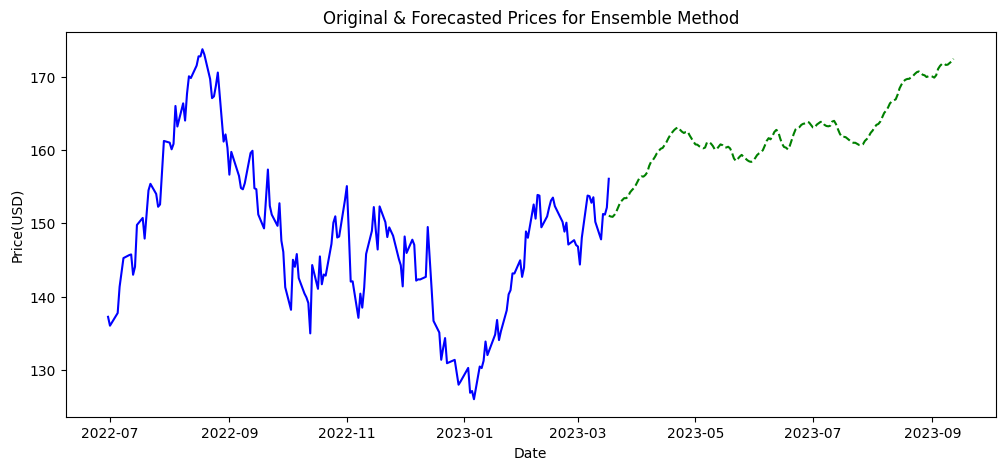

In [67]:
# Create a date range for forecast index
forecast2_index = pd.date_range(start=start_date, periods=len(ensemble_forecast), freq='D')  # 'D' stands for daily frequency.

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(data['Date'].loc[six_months_ago:], original_series_last_6_months, label='Original Data', color='blue')
plt.plot(forecast1_index, ensemble_forecast, label='Forecasted Data', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.title('Original & Forecasted Prices for Ensemble Method')
predicted_original_values
plt.show()